In [1]:
import SimPEG as simpeg
import simpegMT as simpegmt
import numpy as np, os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
## Setup the modelling
# Setting up 1D mesh and conductivity models to forward model data.

# Frequency
nFreq = 31
freqs = np.logspace(3,-3,nFreq)
# Set mesh parameters
ct = 20
air = simpeg.Utils.meshTensor([(ct,16,1.4)])
core = np.concatenate( (  np.kron(simpeg.Utils.meshTensor([(ct,10,-1.3)]),np.ones((5,))) , simpeg.Utils.meshTensor([(ct,5)]) ) )
bot = simpeg.Utils.meshTensor([(core[0],10,-1.4)])
x0 = -np.array([np.sum(np.concatenate((core,bot)))])
# Make the model
m1d = simpeg.Mesh.TensorMesh([np.concatenate((bot,core,air))], x0=x0)

# Setup model varibles
active = m1d.vectorCCx<0.
layer1 = (m1d.vectorCCx<-500.) & (m1d.vectorCCx>=-800.)
layer2 = (m1d.vectorCCx<-3500.) & (m1d.vectorCCx>=-5000.)
# Set the conductivity values
sig_half = 2e-3
sig_air = 1e-8
sig_layer1 = .2
sig_layer2 = .2
# Make the true model
sigma_true = np.ones(m1d.nCx)*sig_air
sigma_true[active] = sig_half
sigma_true[layer1] = sig_layer1
sigma_true[layer2] = sig_layer2
# Extract the model 
m_true = np.log(sigma_true[active])
# Make the background model
sigma_0 = np.ones(m1d.nCx)*sig_air
sigma_0[active] = sig_half
m_0 = np.log(sigma_0[active])

# Set the mapping
actMap = simpeg.Maps.ActiveCells(m1d, active, np.log(1e-8), nC=m1d.nCx)
mappingExpAct = simpeg.Maps.ExpMap(m1d) * actMap

In [3]:
## Setup the layout of the survey, set the sources and the connected receivers

# Receivers 
rxList = []
for rxType in ['z1dr','z1di']:
    rxList.append(simpegmt.SurveyMT.RxMT(simpeg.mkvc(np.array([0.0]),2).T,rxType))
# Source list
srcList =[]
for freq in freqs:
        srcList.append(simpegmt.SurveyMT.srcMT_polxy_1Dprimary(rxList,freq))
# Make the survey
survey = simpegmt.SurveyMT.SurveyMT(srcList)
survey.mtrue = m_true
# Set the problem
problem = simpegmt.ProblemMT1D.eForm_psField(m1d,sigmaPrimary=sigma_0,mapping=mappingExpAct)
from pymatsolver import MumpsSolver
problem.solver = MumpsSolver
problem.pair(survey)

In [4]:
## Forward model observed data 
# Project the data
std = 0.05 # 5% std
if os.path.isfile('MT1D_dtrue.npy') and os.path.isfile('MT1D_dobs.npy'):
    d_true = np.load('MT1D_dtrue.npy')
    d_obs = np.load('MT1D_dobs.npy')
else:
    d_true = survey.dpred(m_true)
    np.save('MT1D_dtrue.npy',d_true)
    d_obs = d_true + std*abs(d_true)*np.random.randn(*d_true.shape)
    np.save('MT1D_dobs.npy',d_obs)
# Assign the dobs
survey.dtrue = d_true
survey.dobs = d_obs
survey.std = np.abs(survey.dobs*std) + 0.01*np.linalg.norm(survey.dobs) #survey.dobs*0 + std
# Assign the data weight
survey.Wd = 1/survey.std #(abs(survey.dobs)*survey.std)

In [5]:
## Setup the inversion proceedure

# Define a counter
C =  simpeg.Utils.Counter()
# Set the optimization
opt = simpeg.Optimization.InexactGaussNewton(maxIter = 30)
opt.counter = C
opt.LSshorten = 0.5
opt.remember('xc')
# Data misfit
dmis = simpeg.DataMisfit.l2_DataMisfit(survey)
# Regularization
# Either have to use 
if True:
    regMesh = simpeg.Mesh.TensorMesh([m1d.hx[problem.mapping.sigmaMap.maps[-1].indActive]],m1d.x0)
    reg = simpeg.Regularization.Tikhonov(regMesh)
else:
    reg = simpeg.Regularization.Tikhonov(m1d,mapping=mappingExpAct)
reg.smoothModel = False
reg.alpha_s = 1e-7
reg.alpha_x = 1.
# reg.alpha_xx = .001
# Inversion problem
invProb = simpeg.InvProblem.BaseInvProblem(dmis, reg, opt)
invProb.counter = C
# Beta cooling
beta = simpeg.Directives.BetaSchedule()
betaest = simpeg.Directives.BetaEstimate_ByEig(beta0_ratio=0.75)
targmis = simpeg.Directives.TargetMisfit()
saveModel = simpeg.Directives.SaveModelEveryIteration()
saveModel.fileName = 'Inversion_TargMisEqnDregMesh_smoothFalse'
# Create an inversion object
inv = simpeg.Inversion.BaseInversion(invProb, directiveList=[beta,betaest,targmis,saveModel]) 


In [6]:
# Run the inversion, given the background model as a start.
mopt = inv.run(m_0)

SimPEG.InvProblem will set Regularization.mref to m0.
SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.l2_DataMisfit is creating default weightings for Wd.
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_TargMisEqnDregMesh_smoothFalse.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  1.40e+05  2.18e+05  0.00e+00  2.18e+05    4.01e+04      0              
   1  1.40e+05  2.50e+04  2.22e-03  2.53e+04    5.66e+03      0              
   2  1.40e+05  3.35e+03  4.89e-03  4.04e+03    9.84e+02      0   Skip BFGS  
   3  1.75e+04  1.58e+03  6.55e-03  1.69e+03    2.60e+02      0   Skip BFGS  
   4  1.75e+04  7.68e+02  2.89e-02  1.28e+03    2.85e+02      0              
   5  1.75e+04  7.2

/home/gudni/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2834: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  if (obj.__array_interface__["data"][0]
/home/gudni/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:2835: FutureWarning: Numpy has detected that you (may be) writing to an array returned
by numpy.diagonal or by selecting multiple fields in a record
array. This code will likely break in a future numpy release --
see numpy.diagonal or arrays.indexing reference docs for details.
The quick fix is to make an explicit copy (e.g., do
arr.diagonal().copy() or arr[['f0','f1']].copy()).
  != self.__array_interface__["data"][0]):


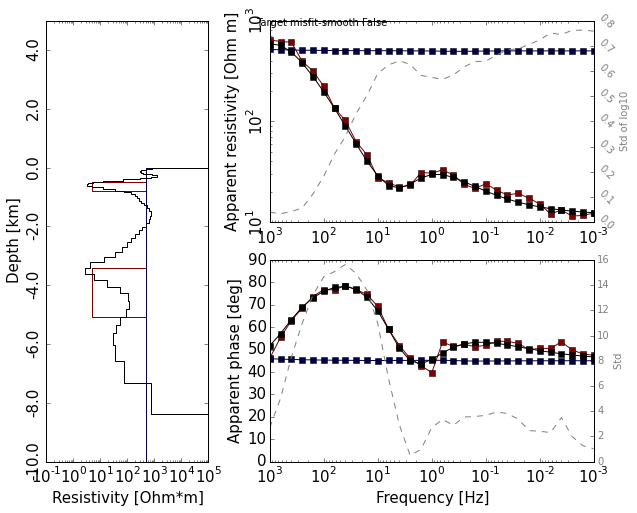

In [7]:
%matplotlib inline
simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[m_0,mopt])
plt.suptitle('Target misfit-smooth False')
plt.show()


In [8]:
reg.alpha_xx = 0.001
saveModel.fileName = 'Inversion_TargMisEqnDregMesh_smoothFalseWxx'

In [9]:
moptWxx = inv.run(m_0)

SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using same solver as the problem***
SimPEG.SaveModelEveryIteration will save your models as: '###-Inversion_TargMisEqnDregMesh_smoothFalseWxx.npy'
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
   0  2.39e+05  2.18e+05  0.00e+00  2.18e+05    4.01e+04      0              
   1  2.39e+05  2.50e+04  2.21e-03  2.55e+04    5.64e+03      0              
   2  2.39e+05  3.36e+03  4.76e-03  4.50e+03    9.90e+02      0   Skip BFGS  
   3  2.99e+04  1.75e+03  5.04e-03  1.91e+03    2.80e+02      0   Skip BFGS  
   4  2.99e+04  9.62e+02  1.78e-02  1.49e+03    2.24e+02      0   Skip BFGS  
   5  2.99e+04  7.14e+02  1.93e-02  1.29e+03    1.09e+02      0              
   6  3.74e+03  5.87e+02  2.24e-02  6.71e+02    1.34

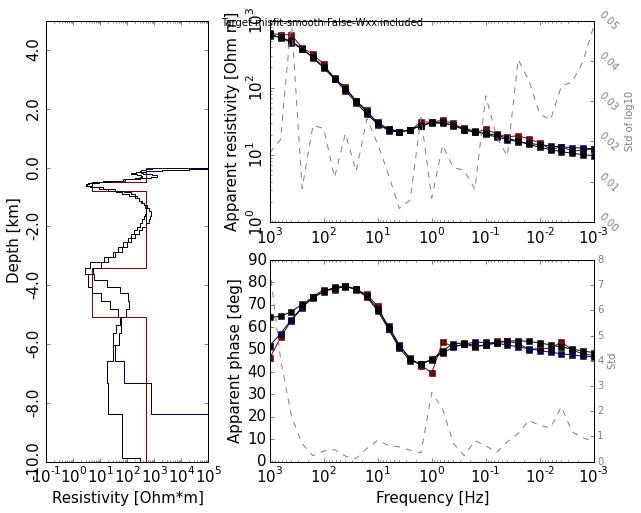

In [10]:
%matplotlib inline
simpegmt.Utils.dataUtils.plotMT1DModelData(problem,[mopt,moptWxx])
plt.suptitle('Target misfit-smooth False-Wxx included')
plt.show()

array([  1.56364893e+00,   1.62641903e+00,   9.96327507e-01,
         1.44424654e+00,   6.30578509e-01,   1.23401217e+00,
         3.24085433e-01,   8.22697458e-01,   1.76735724e-01,
         6.03074990e-01,   9.58662944e-02,   4.08215049e-01,
         5.98116441e-02,   2.51972974e-01,   3.54653904e-02,
         1.75450200e-01,   2.56228377e-02,   1.08572300e-01,
         2.02929041e-02,   7.36028696e-02,   1.64620388e-02,
         4.35752349e-02,   1.80228828e-02,   3.00269993e-02,
         1.63486779e-02,   2.07561568e-02,   1.48651221e-02,
         1.54284013e-02,   1.44530319e-02,   1.33959072e-02,
         1.19683391e-02,   9.92609378e-03,   7.65168460e-03,
         1.02732372e-02,   6.00068131e-03,   7.50916027e-03,
         4.18767716e-03,   5.42181442e-03,   3.25257531e-03,
         4.05629002e-03,   2.68596740e-03,   3.42401859e-03,
         1.90915942e-03,   2.59005940e-03,   1.43069528e-03,
         1.94836445e-03,   1.18442707e-03,   1.55686635e-03,
         9.44647001e-04,

array([ -4.30174521e-02,  -2.82476125e-02,  -1.12416190e-02,
         1.16416209e-01,  -6.26268459e-02,  -1.72987726e-02,
         3.33927883e-03,  -1.28190065e-01,  -1.99208335e-02,
         5.43972252e-03,   7.85202615e-03,   6.20311032e-03,
         2.04136058e-03,   9.56190481e-03,  -1.09499039e-04,
        -1.03789061e-02,   9.53663363e-04,  -4.19335702e-05,
        -1.64251310e-04,  -2.59815192e-03,  -6.75066243e-04,
        -1.49936092e-03,  -3.33456950e-04,   2.44076361e-03,
        -7.33153707e-04,  -9.61669258e-04,   5.97912054e-04,
        -6.83894797e-04,   7.26002326e-04,  -3.60787807e-04,
         1.68289077e-04,   3.31670038e-04,   9.45753316e-05,
         3.30271734e-04,  -2.26943406e-04,   2.11135875e-04,
         6.80321836e-05,   1.62860800e-04,  -1.84990894e-04,
        -5.71275809e-05,   1.37379585e-04,  -1.99667211e-04,
         7.01025135e-05,  -1.01077045e-04,  -2.60300325e-05,
         9.37896779e-05,   2.50865054e-05,   2.79492481e-05,
        -1.02976226e-05,